In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from google.colab import drive
drive.mount('/content/drive')
%ls

Mounted at /content/drive
drive/                        inphase_quadrature_library.npy  sample_data/
inphase_quadrature_data.json  inphase_quadrature_noise.json


In [ ]:
# Read the uploaded files with data and noise
with open('inphase_quadrature_data.json') as f:
  data = np.array(json.load(f))
with open('inphase_quadrature_noise.json') as f:
  noise = np.array(json.load(f))
# Read the library files with centroids for Support Vector Machine
iq_lib = np.load('inphase_quadrature_library.npy')

In [ ]:
# Convert in-phase and quadrature signals to the complex-valued
# All operations below will be in the comples space
iqdata = data[:,0,:] + 1j*data[:,1,:]
iqnoise = noise[:,0,:] + 1j*noise[:,1,:]
# np.save('iq_data.npy', iqdata)
# np.save('iq_noise.npy', iqnoise)

In [ ]:
# Signal processing
#import pywt # Discrete wavelet transform
#from scipy.ndimage import gaussian_filter1d
#import scipy.signal as signal

# Classification
#import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
# Prepare a two-class classification dataset: one versus two transmitters
# Assume that the signal amplitude attenuates proportionally to the distance to the reader and set
n = len(iqdata) # Occurs below frequently
# Randomly select indices from the sample set
indices = np.random.choice(n, n, replace=False)
iqdata2 = iqdata[indices]
# Same, decouple the noise idices and signal indices
indices = np.random.choice(n, n, replace=False)
iqnoise2 = iqnoise[indices]
# Blend the original data noise, too
indices = np.random.choice(n, n, replace=False)
iqnoise = iqnoise[indices]

# Gather all four matrices into one dataset with the target labels
# FIX put the right formula with phase shift here and make it randomly changing
attenuation = np.array([.5, .5])
Xsrc = np.concatenate((
    iqdata + iqnoise,
    attenuation[0] * iqdata + attenuation[1] * iqdata2 + iqnoise2),
                      axis=0)
Ysrc = np.concatenate((np.zeros(n), np.ones(n)), axis=0) # Real only
# Plot the dataset to be sure
# plt.imshow(Xsrc.imag[950:1050,:], cmap="viridis", interpolation="nearest")
# plt.show()
# plt_rand(Xsrc, Xdenoise, 3)

In [ ]:
def proj_xy(x, y):
  # Computes the projection of vector x onto vector y
  # Works with dtype=complex
  if np.all(y == 0):
      raise ValueError("Projection is undefined for a zero vector y.")
  return (np.dot(x,y) / np.dot(y, y)) * y

def scale_x2max(x, amp = 1 + 1j):
  # The expectred amplitude of the iqdata is between 0.3 and 1.2 V. Set to 1 V
  # Works with dtype=complex
  if np.all(x == 0):
        raise ValueError("Scaling is impossible for a zero vector x.")
  z = np.zeros(len(x), dtype=complex)
  z.real = amp.real * x.real / np.max(np.abs(x.real))
  z.imag = amp.imag * x.imag / np.max(np.abs(x.imag))
  return z

def check_consecutive_sum(x, N, C):
  # Checks if the sum of any N consecutive elements in the vector does not exceed C
  # Works with dtype=complex
  if N > len(x):
      return np.sum(x.real) <= C and np.sum(x.imag) <= C  # If N is larger than the vector length, check entire sum
  current_sum = sum(x[:N]) # Compute initial window sum
  if current_sum.real > C or current_sum.imag > C:
      return False
  for i in range(N, len(x)): # Use sliding window
      current_sum += x[i] - x[i - N]
      if current_sum.real > C or current_sum.imag > C:
          return False
  return True

def complex_abs(x, y):
  # Absolute values of the residues elements of two complex vectors
  # Works with dtype=complex
  z = np.empty(x.shape, dtype=complex)
  z.real = np.abs(x.real - y.real)
  z.imag = np.abs(x.imag - y.imag)
  return z

def dist_xy(x,y):
  # Works with dtype=complex
  return np.linalg.norm(x - y)

def find_best_shift(x, y, N, is_proj = False):
  # Find the best phase of y to minimize the distance to x
  # N is the maximum allowed phase shift in either direction
  # Works for complex-valued vectors
  min_residue = float('inf')
  best_shift = 0

  # The shifting runs two times, put it to a function
  def shift_it(x, y, len_x, shift):
    if shift < 0:
      shifted_y = np.pad(y[:len_x + shift], (abs(shift), 0), 'constant', constant_values=0)
    else:
      shifted_y = np.pad(y[shift:], (0, shift), 'constant', constant_values=0)
    return shifted_y

  len_x = len(x)
  for shift in range(-N, N + 1):
    shifted_y = shift_it(x, y, len_x, shift)

    if is_proj:
      shifted_y = proj_xy(x, shifted_y)
    residue = np.linalg.norm(x - shifted_y)

    if residue < min_residue:
      min_residue = residue
      best_shift = shift

  shifted_y = shift_it(x, y, len_x, best_shift)
  if is_proj:
    shifted_y = proj_xy(x, shifted_y)
  return shifted_y

In [ ]:
# Generate the metric features: compute distance from an object to each centroid
Xdist = np.empty((len(Xsrc), len(iq_lib)))
Xrbf = np.empty((len(Xsrc), len(iq_lib)))
Gamma = 1.0
for i in range(len(Xsrc)):
  for j in range(len(iq_lib)):
    # Variant without phase shifting
    Xdist[i,j] = dist_xy(
        proj_xy(
            iq_lib[j],
            Xsrc[i]),
        iq_lib[j])
    # Variant with phase shifting
    Xdist[i,j] = dist_xy(
        find_best_shift(
            iq_lib[j],
            Xsrc[i],
            5,
            True),
        iq_lib[j])
    # Radial Basis Function for classification
    Xrbf[i,j] = np.exp(-Gamma * Xdist[i,j]**2)

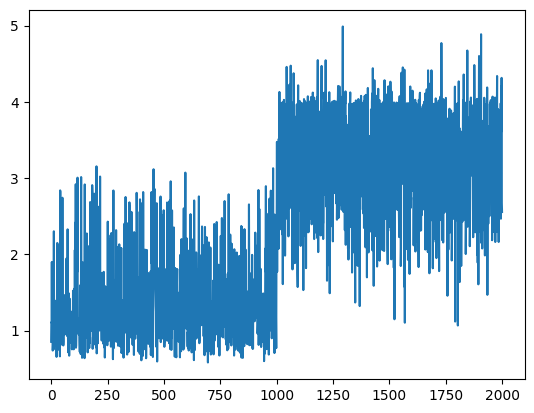

In [ ]:
creterion = np.min(Xdist, axis=1)
plt.plot(creterion)
plt.show()

In [ ]:
def plt_rand(X, X1, n): # X and X1 must be of the same shape
  indices = np.random.choice(len(X), n, replace=False)# [0] # Pick an item
  for index in indices:
    plt.plot(X.real[index], label = 'Original, re', linestyle='dashed')
    plt.plot(X.imag[index], label = 'Original, im', linestyle='dashed')
    plt.plot(X1.real[index], label = 'Reconstructed, re')
    plt.plot(X1.imag[index], label = 'Reconstructed, im')
    plt.rcParams['font.family'] = 'DejaVu Serif'
    plt.rcParams['lines.linewidth'] = 2
    #plt.rcParams['lines.markersize'] = 12
    plt.rcParams['xtick.labelsize'] = 12#24
    plt.rcParams['ytick.labelsize'] = 12#24
    plt.rcParams['legend.fontsize'] = 12#24
    plt.rcParams['axes.labelsize'] = 10#24
    plt.xlabel('Time ticks', fontname='DejaVu Serif')
    plt.ylabel('Amplitude, V', fontname='DejaVu Serif')
    plt.legend()
    plt.show()

In [ ]:
# Filter Gaussian noise by the median averaging, small window ??? CHECK! how to filter IQdata
Xdenoise = np.empty(Xsrc.shape, dtype=complex)

# window_size = 3 # Filtering parameters
# kernel = np.ones(window_size, dtype=complex) / window_size  # Create averaging kernel

for x, i in zip(Xsrc, range(len(Xsrc))):
  Xdenoise[i] = gaussian_filter1d(x, sigma=1)
  # Xdenoise[i] = signal.convolve(x, signal.gauss_spline(51, 7), mode='same') / sum(signal.gauss_spline(51, 7)) # Apply Gaussian filter
  #Xdenoise[i].real = np.convolve(x.real, kernel, mode='same')  # Apply convolution
  #Xdenoise[i].imag = np.convolve(x.imag, kernel, mode='same')  # Apply convolution

#plt.plot(z.imag)
#plt.show()

plt_rand(Xsrc, Xdenoise, 3)

NameError: name 'gaussian_filter1d' is not defined

In [ ]:
# Extract features from SSA
ncols = 10
ncomps = 5
Xssa = np.empty(Xsrc.shape, dtype=complex)
Xhr = np.empty(Xsrc.shape, dtype=complex)
Xlambd = np.empty((len(Xsrc), ncomps), dtype=complex)
Xrotat = np.empty((len(Xsrc), ncomps**2), dtype=complex)

for x, i in zip(Xdwt, range(len(Xsrc))):
  # Extract singular values and vectors from SVD of the Hankel matrix
  Xssa[i], _, _, Xlambd[i], rotat  = ssa(x, ncols, ncomps)
  rotat = rotat[:,:ncomps]
  Xrotat[i]  = rotat.reshape(-1)

plt_rand(Xdwt, Xssa, 3)

In [ ]:
# Feature egineering
Xenergy = np.sum(np.abs(Xsrc)**2, axis=1)
# Feature collecting
Xea = np.concatenate((Xenergy.reshape(-1, 1), Xlambd.real, Xlambd.imag, Xrotat.real, Xrotat.imag), axis=1)

In [ ]:
# Metric feature engineering
iq_idx_centroids = np.load('iq_idx_centroids.npy')
Xmetric = np.empty((len(Xsrc), len(iq_idx_centroids)))
for i in range(len(Xsrc)):
  d = np.empty(len(iq_idx_centroids))
  for j, i_idx in zip(range(len(iq_idx_centroids)), iq_idx_centroids):
    obj = Xsrc[i]
    obj = obj / np.sqrt(np.sum(np.abs(obj)**2))
    # print(i_idx.astype(int))
    centroid = iqdata[i_idx.astype(int)]
    centroid = centroid / np.sqrt(np.sum(np.abs(centroid)**2))
    d[j] = np.linalg.norm(obj - centroid)
  Xmetric[i] = d

In [ ]:
def get_LogRegression_AUC(X,y):
  #------------------------------------------------------------------
  # Split into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  #------------------------------------------------------------------
  # Logistic regression
  model = LogisticRegression() # Create the logistic regression model
  model.fit(X_train, y_train) # Train the model
  y_pred = model.predict(X_test) # Make predictions
  y_pred_proba = model.predict_proba(X_test)[:, 1] # Get probabilities for ROC curve

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  #print("Accuracy (logistic regression):", accuracy)
  #print("Classification Report:\n", report)

  # Calculate and plot ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
#------------------------------------------------------------------
  return auc, accuracy, fpr, tpr

In [ ]:
Xea = np.concatenate((Xenergy.reshape(-1, 1), Xlambd.real, Xlambd.imag, Xmetric), axis=1)

In [ ]:
# Classify the data set with logistic regression and kNN

X = Xrbf #Xea
y = Ysrc


auc, accuracy, fpr, tpr = get_LogRegression_AUC(X,y)





plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
#plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 12#24
plt.rcParams['ytick.labelsize'] = 12#24
plt.rcParams['legend.fontsize'] = 12#24
#plt.rcParams['axes.titlesize'] = 36.
plt.rcParams['axes.labelsize'] = 12#24
plt.gca().set_aspect('equal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

plt.show()
#------------------------------------------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # The number of neighbors, k
knn.fit(X_train, y_train) # Fit the model
y_pred = knn.predict(X_test) # Make predictions
auc = roc_auc_score(y_test, y_pred)
# Calculate AUC score and accuracy
print("AUC:", auc)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy (kNN):", accuracy)
print("Classification Report:\n", report)

In [ ]:
DSIZE = 1000
sample_sizes = np.linspace(200, DSIZE, 30, dtype=int)
class_ratios = np.linspace(0.2, 0.95, 30)

pltX, pltY = np.meshgrid(sample_sizes, class_ratios)
pltZauc = np.empty(pltX.shape)
pltZacc = np.empty(pltX.shape)

for sample_size, i in zip(sample_sizes, range(len(sample_sizes))):
  for class_ratio, j in zip(class_ratios, range(len(class_ratios))):
    # Select random ss and ss/cr elements from the dataset
    indices_0 = np.random.choice(DSIZE, sample_size, replace=False)
    indices_1 = DSIZE + np.random.choice(DSIZE, int(sample_size * class_ratio), replace=False)
    indices = np.concatenate((indices_0, indices_1))
    # print(len(indices_0), len(indices_1), len(indices))
    Xcut = Xrbf[indices]
    Ycut = Ysrc[indices]
    auc, accuracy, fpr, tpr = get_LogRegression_AUC(Xcut,Ycut)
    pltZauc[i,j] = auc
    pltZacc[i,j] = accuracy


In [ ]:
# Smooth the mechgrid a little to understand the structire of the surface

pltZsmooth = np.empty(pltX.shape)
for i in range(len(pltX)-1):
  for j in range(len(pltX)-1):
    if j == 0:
      vec = np.array([
          pltZauc[i,j],
          pltZauc[i-1,j],
          pltZauc[i+1,j],
          pltZauc[i,j+1],
          pltZauc[i+1,j+1]])
    elif i+j == 0:
      vec = np.array([
          pltZauc[i,j],
          pltZauc[i+1,j],
          pltZauc[i,j+1],
          pltZauc[i+1,j+1]])
    else:
      vec =np.array([
          pltZauc[i,j],
          pltZauc[i,j-1],
          pltZauc[i,j+1],
          pltZauc[i-1,j],
          pltZauc[i+1,j]])
    mean_val = np.mean(vec)
    if mean_val < 0.8:
      # Report the mean value and put it to the minimum
      print('mean value is low, please check')
      mean_val = 0.8
    pltZsmooth[i,j] = mean_val
    # print(i,j, vec, pltZsmooth[i,j])


# Remove the last row and columns
pltX = pltX[:-1, :-1]
pltY = pltY[:-1, :-1]
pltZsmooth = pltZsmooth[:-1, :-1]
pltZauc = pltZauc[:-1, :-1]
pltZacc = pltZacc[:-1, :-1]

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
# ax.plot_wireframe(pltX, pltY, pltZauc, color='red')
ax.plot_surface(pltX, pltY, pltZauc, cmap='viridis')
#ax.plot_surface(pltX, pltY, pltZsmooth, cmap='viridis')
ax.set_xlabel('Number of transmissions')
ax.set_ylabel('Proportion of collisions')
ax.set_zlabel('AUC', rotation=90)
ax.view_init(elev=30, azim=230)
#ax.set_zlim(0.8, 1)
plt.show()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
# ax.plot_wireframe(pltX, pltY, pltZauc, color='red')
# ax.plot_surface(pltX, pltY, pltZauc, cmap='viridis')
ax.plot_surface(pltX, pltY, pltZsmooth, cmap='viridis')
ax.set_xlabel('Number of transmissions')
ax.set_ylabel('Proportion of collisions')
ax.set_zlabel('AUC', rotation=90)
ax.view_init(elev=30, azim=230)
#ax.set_zlim(0.8, 1)
plt.show()
